# 데이터베이스 기반 사이트 웹 크롤링

science_on_keyword_search 에서 https://scienceon.kisti.re.kr/main/mainForm.do 에서  keyword를 사용해서 논문의 초록과 제목을 가져와서 논문에서 자주 사용되는 단어를 알아보는 것을 수행했다. 이번에는 논문들의 제목과 초록, 논문의 키워드를 가지고 RNN 학습을 시키기 위해 모든 논문을 가져오는 웹 크롤링을 만들어 본다.

science_on는 서버의 데이터베이스에서 keyword로 검색을 한 뒤 그에 따른 논문의 리스트를 반환한다.

science_on에서 논문을 검색하는 방법은 keyword 검색을 통한 방법 밖에 없다.

따라서 모든 논문을 가져오기 위해서는 모든 단어로 검색을 한 뒤 논문을 가져오는 방법 밖에 없다.

웹 크롤링을 통해 데이터베이스 정보를 가져오기 위해 어떤 수법을 사용했는지 설명하고자 한다.

### 주요하게 생각한 부분
웹 크롤링을 하기 위해서 가장 중요한 부분은 서버에 부담을 주지 않는 것이다. 
1. 크롤링한 논문은 다시 크롤링 하지 않는다.
2. 서버가 차단하는 기준을 알아야 한다.
3. 생각지 못한 문제가 발생하거나 수정하고 싶은 부분이 생겼을 때를 대비해서 데이터 손실에 주의한다.



### 코드 설명

science_on는 서버와 post 방식으로 통신한다. 

In [1]:
from konlpy.tag import Okt
import requests
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen, Request
from urllib.parse import urlencode
import pandas as pd
import pickle
import time
import re

아래는 post할 때 body 부분에 넣어지는 form 데이터이다.

모든 key의 value를 바꿔보며 시험해본 결과  

filter : 분류,  
logKeyword : 입력 keyword,  
sortby1,2 : 정렬 기준(종류, 오름내림),  
rowCount : 리스트 개수(최대 2000-시간이 오래 걸림)

나머지는 필요없거나 정체를 밝혀내지 못했다.  

In [2]:
form={
'filter4': 'kor',
'saveLog': '0',
'logKeyword': '입력',
'class2': '',
'oldSearchKeyword':'', 
'searchKeyword': '',
'searchCondition': 'thesis',
'srchFlag': '',
'startIndex': '',
'endIndex': '',
'gubunCd': '',
'exportFlag':'', 
'sortby1': 'sort_title',
'sortby2': 'DESC',
'rowCount': '1000',
'pageIndex': '1',
'cloudBtn': '1'
}

science_on에서는 아래와 같이 do 파일을 주고 받으면서 사이트를 만든다.
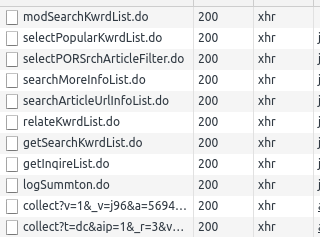

미리 변수를 선언함으로서 행에서 에러가 발생해도 발생한 부분의 전 단계의 상태를 유지 할 수 있다.

In [26]:
filter_url="https://scienceon.kisti.re.kr/srch/selectPORSrchArticleFilter.do"  # 필터의 종류을 포함한 do 요청 url
word_url='https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn='      # 특정 논문 출력 do 요청 url
URL='https://scienceon.kisti.re.kr/srch/selectPORSrchArticleList.do'           # keyword 입력으로 논문 정보을 포함한 do 요청 url
did=set()       # 검색 했던 단어를 저장
did_url=set()   # 검색 했던 논문의 id를 저장
do=['논문']     # 검색 해야되는 단어들을 저장
num=0           

fail_row=[]     # 각 단계별 에러가 발생한 부분을 저장
fail_filter=[]
fail_year=[]
fail_month=[]
fail_word=[]
over_20000=[]


keyword로 검색을 하게 되면 검색된 논문이 10000개가 넘는다면 10000개 이후의 논문은 보여주지 않는다.  
또한 정렬 기준이 명확하지 않은 정확도, 발행 날짜로 하면 같은 요청에도 논문들의 정렬 순서가 바뀐다. 

그래서 논문명으로 정렬 기준을 잡아 논문의 정렬 순서가 바뀌지 않게 했으며, 오름내림차를 바꿔 한 keyword로 논문을 20000개까지 논문을 요청할 수 있도록 하였다.

또한, 검색 필터 중에서는 아래와 같은 필터가 있는데, 여기서 한국어만 나오도록 하였고, 발행연도 별로 논문들을 요청해 
각 keyword의 (한국어, 발생연도) 별로 최대 20000개까지 요청할 수 있는 웹 크롤링을 만들었다.

※ keyword의 (한국어, 발생연도)에서 20000개가 넘으면 20000개까지 크롤링을 한 뒤 발생한 keyword와 연도를 over_20000에 저장한다. 
(다른 keyword에서 20000개가 넘어 못 가져온 부분을 가져올 수도 있다.)  
(나중에 over_20000에 있는 부분들을 정확도, 발행 날짜 등으로 정렬한 뒤 데이터를 가져올 수 있다.)

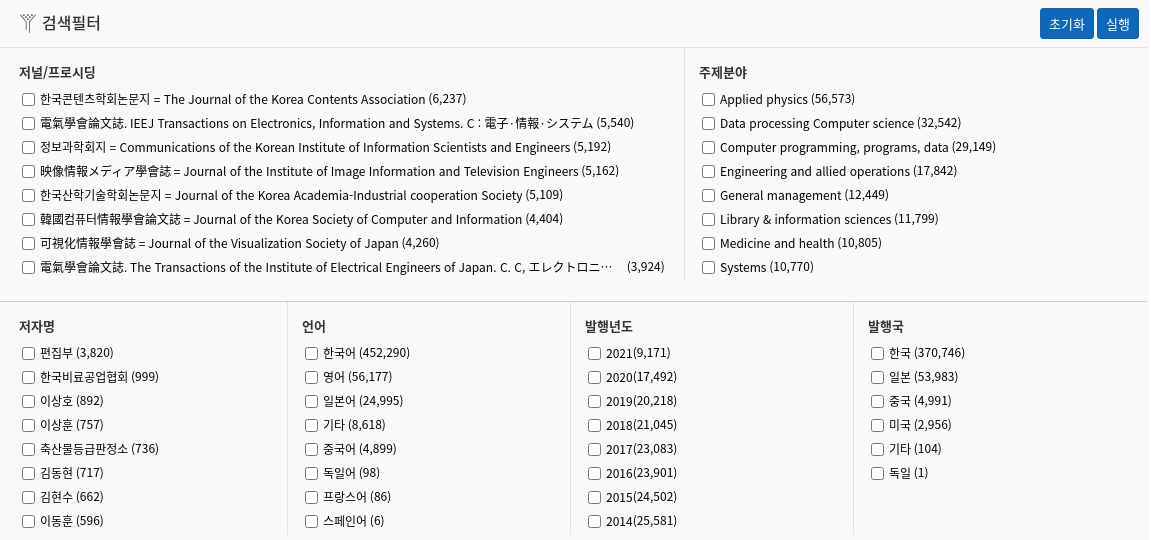

-----
아래에 있는 검색 연산자를 사용해서 검색을 할 방법도 연구해 봤다.
데이터베이스에서 공백,! 같은 연산자를 사용해서  
20000개가 넘는 keyword A  
A 공백 B 로 검색하고 A!B를 검색하는 방법을 생각했다.

하지만 A의 개수 !=  (A 공백 B 의 개수) + (A!B의 개수) 라 보류를 하게 됐다.




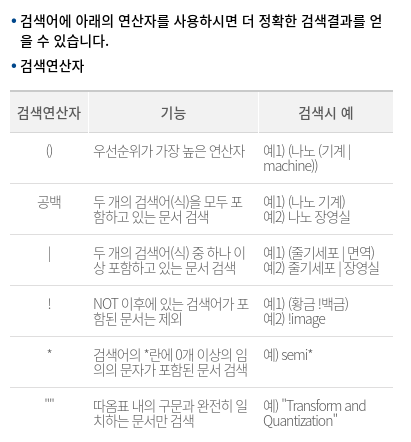

-----

In [4]:
# filter_url="https://scienceon.kisti.re.kr/srch/selectPORSrchArticleFilter.do"


# fail_filter=[]
def make_year_list(keyword):
    if form.get('filter3',False):
        del form['filter3']
    form['logKeyword']=keyword
    form['searchKeyword']=keyword
    p = re.compile('[0-9]{4}')      # string에서 연도를 꺼내는 정규표현식
    years=[]
    counts=[]
    
    encData = urlencode(form)       # post 할 form의 형식을 bytes로 바꾸는 과정
    post = bytes(encData,encoding='utf-8')
    
    for _ in range(3):              # 서버에 요청이 성공할 때까지 3번 시도한다.
        try:
            with urlopen(filter_url,data=post) as req:   # 웹 서버에 웹페이지 요청
                code = req.status            # 응답 성공 여부
            #         print(code)
                if code==200:                # 응답이 성공하면 BeautifulSoup를 반환
                    soup=bs(req.read(),'lxml')
                    break
                else:
                    print('year fail')
        except Exception as e:       # 서버에서 거부한다고 판단 300초 동안 기다리며 서버에 부하를 가하지 않으려 노력했다.
            print('urlerror0 : ',e)
            time.sleep(300)
            code=0
        finally:
            time.sleep(9)
            
    if code==200:       

        y_bs=soup.find_all("input",{"name":"filter3"})   # BeautifulSoup에서 연도,연도 개수를 리스트로 만들어 반환
        for row in y_bs:
            if p.match(row['value']):
                years.append(row['value'])
                try:
                    counts.append(int(row['data-count']))
                except:
                    print(keyword,"have error filter")
                    fail_filter.append(keyword)          # 실패하면 fail_filter로 저장
    else:
        fail_month.append(keyword)
    return years,counts
# _ , co=make_year_list('도서관 이용자')
# sum(co)

위에 함수는 keyword의 필터에서 발행연도가 몇 년들이 있고 그 연도의 개수를 저장한 리스트를 반환한다.  


In [5]:
make_year_list('도서관 이용자')

(['2021',
  '2020',
  '2019',
  '2018',
  '2017',
  '2016',
  '2015',
  '2014',
  '2013',
  '2012',
  '2011',
  '2010',
  '2009',
  '2008',
  '2007',
  '2006',
  '2005',
  '2004',
  '2003',
  '2002',
  '2001',
  '2000',
  '1999',
  '1998',
  '1997',
  '1996',
  '1995',
  '1994',
  '1993',
  '1992',
  '1991',
  '1990',
  '1989',
  '1988',
  '1987',
  '1986',
  '1985',
  '1984',
  '1983',
  '1981',
  '1980',
  '1979',
  '1977',
  '1976',
  '1974'],
 [77,
  229,
  244,
  259,
  257,
  254,
  315,
  335,
  326,
  330,
  304,
  315,
  295,
  213,
  141,
  111,
  110,
  86,
  84,
  77,
  63,
  61,
  37,
  43,
  23,
  17,
  21,
  14,
  9,
  13,
  10,
  8,
  5,
  6,
  3,
  2,
  2,
  6,
  2,
  2,
  2,
  3,
  3,
  1,
  1])

검색할 keyword는 논문에서 쓰여있는 주제어(키워드)에 들어있는 단어를 사용해서 검색한다.  
검색할 때 주제어에 쓰여 있는 것을 okt를 사용해 명사만 꺼내어 keyword로 사용한다.

아래는 okt를 통해 주제어에서 명사들을 리스트로 반환하는 함수이다.


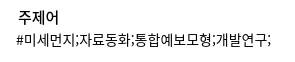

In [6]:
from konlpy.tag import Okt

def okt(data):
    try:
        lis=ok.pos(data)
        temp_noun=[]
        for row in lis:
            if row[1]=="Noun":
                temp_noun.append(row[0])

        return temp_noun
    except:
        print("fail",data)
        return []
    
ok=Okt()

In [9]:
okt('미세먼지;자료동화;통합예보모형;개발연구;')

['미세먼지', '자료', '동화', '통합', '예보', '모형', '개발', '연구']

아래는 science_on 사이트에 키워드가 쓰여있지 않고 kci 라는 논문 사이트에 적혀있기 대문에 kci 사이트로 이동해서 그 부분을 가져오는 코드이다.

여기서 키워드는 무엇이고 명사 단어는 무엇인지 반환한다.

In [11]:

def kci(url):
    words=''
    for _ in range(3):
        try:
            with urlopen(url) as req:   # 웹 서버에 웹페이지 요청
                code = req.status          # 응답 성공 여부
            #         print(code)
                if code==200:  
                    soup=bs(req.read(),'lxml') 
                    break
        except Exception as e:
            print('urlerror1 : ',e)
            time.sleep(5)
            code=0
            
    if code==200:                     

#         print(soup)
        div = soup.find_all('a',{'id':'keywd'})
        if len(div)>0:
            temp=[]
            for row in div:
                kci_word=row.get_text()
                temp.append(kci_word)
                words+=' '+kci_word
                
            return temp,okt(words)
    return [],[]
# kci(test)    

In [12]:
test='https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART001303851'
kci(test) 

(['정보복지', '정보격차', '정보접근성', '정보이용능력', '정보활용'],
 ['정보', '복지', '정보격차', '정보', '접근성', '정보', '이용', '능력', '정보', '활용'])

원문을 볼 수 있는 사이트가 있는 데 거기서 kci 사이트가 있으면 이동을 한 뒤 위처럼 키워드와 단어를 가져오는 함수이다.

In [13]:
def different_web(urls):
    http = re.compile("http.+?(?=')")
    kci_fit=re.compile(".+kci\.go\.kr.+")
#     riss_fit=re.compile(".+riss\.kr.+")
    
    lis= []
    for row in urls:
        temp=http.findall(row)
        if len(temp)>0:
            lis.append(temp[0])
            
    for row in lis:
        if kci_fit.match(row):
            key_words,words=kci(row)
            return key_words,words
    return [],[]

science_on 사이트에서 논문의 정보를 받은 뒤 논물 페이지로 이동하는 하고, 주제어를 반환 받는다.

주제가 없으면 위에 함수를 실행한다.

In [16]:
# word_url='https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn='

def search_word(url):
    words=set()
    key_words=set()
    title=word_url+url
    
#         print(code)
    for _ in range(3):
        try:
            with urlopen(title) as req:   # 웹 서버에 웹페이지 요청
                code = req.status          # 응답 성공 여부
            #         print(code)
                if code==200:
                    soup=bs(req.read(),'lxml') 
                    break
        except Exception as e:
            print('urlerror2 : ',e)
            time.sleep(300)
            code=0
        finally:
            time.sleep(10)
            
    if code==200:                  
#         print(title)
        div = soup.find_all('p',{'class':'pl10'})
        if len(div)>0:
            for data in div:
                data=data.get_text()   # bs 형식에서 string으로 변환 후 필요 없는 부분을 제외시킨다.
                data=data.replace('#','').replace('\n','').replace('\t','').replace('\r','').replace('  ','')
#                 print(data)
                key_words.add(data)
                okt_words=okt(data)
                
                if okt_words==[]:
                    print('0' ,title)
                words.update(okt_words)
        else:            
            other_web = soup.find_all('button',{'class':'ico_pdf'})
            if len(other_web)>0:
                temp = [row['onclick'] for row in other_web]
                if len(temp)>0:
                    key_lis_word,lis_word=different_web(temp)
                    words.update(lis_word)
                    key_words.update(key_lis_word)
    return list(key_words),list(words)
# search_word('DIKO0015367430')

In [15]:
search_word('DIKO0015745055')

(['직립제 소파블록;'], ['블록', '제', '직립', '소파'])

아래는 논문의 키워드,연도, 개수를 받고 최대 20000개의 논문에서 제목, 초록, 키워드, 단어 등을 가져온다.

In [24]:
import pandas as pd


def get_link_under_20000(keyword,year,count):
    pd_keyword=pd.DataFrame([])
#     a_links=[]
#     b_links=[]
#     c_links=[]
    urls=[]
    form['filter3']=year
    form['logKeyword']=keyword
    form['searchKeyword']=keyword
    form['sortby2']='DESC'
#     form['sortby1']='_score'
    
#     form['srchFlag']='10001'
#     form['exportFlag']='20000'
#     form['rowCount']='10'
# 'srchFlag': '',
# 'startIndex': '',
# 'endIndex': '',
# 'gubunCd': '',
# 'exportFlag':'',

    n=''
    max_page=(count-1)//int(form['rowCount'])+2     # 'rowCount가 몇 이여도 되게 만든다.
    turn=9999//int(form['rowCount'])+1
    for page in range(1,max_page): #count
#     if page==11:
        print(page,' / ',max_page-1)
        if page>turn:
            n='*'
            form['sortby2']='ASC'   # 논문이 10000개가 넘으면 오른차순으로 바꾼다.
            page=page-turn
            
        form['pageIndex']=str(page)   # 1~10페이지까지 검색
        
        encData = urlencode(form)
        post = bytes(encData,encoding='utf-8')
        
        for _ in range(3):   
            try:
                with urlopen(URL,data=post) as req:  # 웹 서버에 웹페이지 요청   
                    code = req.status            # 응답 성공 여부
                    if code==200:       
                        soup=bs(req.read(),'lxml') 
                        break
                    else :
                        print("html 에서")
            except Exception as e:
                print('urlerror3 : ',e)
                code=0
                time.sleep(300)
            finally:
                time.sleep(10)
            
                
        if code==200:           
            print("start :", code)
                        
            div = soup.find_all('div',{'class':'result_item'})
            print(len(div))
            for data in div:
                url= data["id"].split('_')[-1]
                if url not in did_url:
                    did_url.add(url)
                    key_words,words=search_word(url)
                    
                    title=data.find('a',{'title':'상세보기'})
                    title=title.get_text()
                    title=title.replace('\n','').replace('\t','').replace('\r','').replace('  ','')
#                     print(a_tag)
                    box_st1=''

                    c_tag=data.find('div',{'class':'result_item_info'})  # 나머지 추가 정보
                    c_tag=c_tag.get_text()
                    c_tag=c_tag.replace('\n','').replace('\t','').replace('\r','').replace('  ','')

                        
                    abstract=data.find('div',{"class":"item_content hidden abs"})
                    if abstract != None:# 초록이 없는 경우 제외
                        abstract=abstract.get_text()
                    else :                     # 초록이 없는 논문 리스크 저장
                        num=data.find('span',{'class','num'}).get_text()
                        num=n+num
                        fail_row.append((num,title))
                    # 제목과 초록이 있으면 각각 리스트 저장
                    pd_keyword=pd_keyword.append({'keyword':keyword,'year':year,'url':url,'title':title,'abstract':abstract,'key_words':key_words,'topic':words,'etc':c_tag},ignore_index=True)

                    if len(words)>0:
                        for row in words:
                            if (row not in did) and(row not in do):
                                do.append(row)
        else:                                 # 응답실패
            print('HTTP Error',code)
            fail_year.append(keyword,year,page)
    return pd_keyword



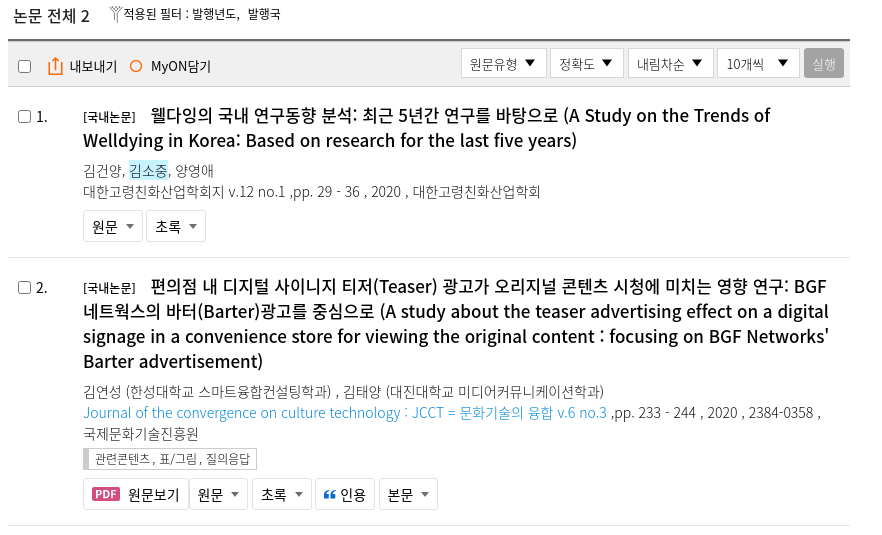

In [27]:
pf=get_link_under_20000('김소중','2020',3)
pf

1  /  1
start : 200
2


,abstract,etc,key_words,keyword,title,topic,url,year
0,"\n우리는 365일, 버스와 지하철에서 편의점, 커피숍, 음식점, 그리고 엘리베이터...","김연성(한성대학교 스마트융합컨설팅학과), 김태양(대진대학교 미디어커뮤니케이션학과)J...",[디지털 사이니지 티저 광고 콘텐츠 바터 광고 시청 의도 ],김소중,[국내논문]편의점 내 디지털 사이니지 티저(Teaser) 광고가 오리지널 콘텐츠 시...,"[사이니, 의도, 콘텐츠, 디지털, 광고, 시청, 티저, 바터]",JAKO202025465016923,2020
1,"\nObjective : Currently, research on well-dyin...","김건양, 김소중, 양영애 대한고령친화산업학회지v.12 no.1,pp. 29- 36,...",[],김소중,[국내논문]웰다잉의 국내 연구동향 분석: 최근 5년간 연구를 바탕으로(A Study...,[],ART002593979,2020


웹 크롤링을 중단했을 때 다음에 이어서 하기 위해 필요한 변수들을 미리 저장해둔다.

KeyboardInterrupt 에러는 jupyter에서 중단 버튼을 눌렀을 때 방생되는 에러로 중단을 눌러 중지할 수 있다.

0 이 나오고 url이 나오는 것은 keyword가 영어인 것이고  
각 에러에 맞게 어떤 에러가 발생했는지 나오고 에러가 나온 부분이 어딘지 저장한다.

In [11]:

if __name__=="__main__":
    with open('data_did_url.pkl','rb') as f:
        did_url=pickle.load(f)

    with open('data_did.pkl','rb') as f:
        did=pickle.load(f)
    with open('data_do.pkl','rb') as f:
        do=pickle.load(f)
    with open('data_over_20000.pkl','rb') as f:
        over_20000=pickle.load(f)
    with open('data_fail_row.pkl','rb') as f:
        fail_row=pickle.load(f)
    with open('data_fail_filter.pkl','rb') as f:
        fail_filter=pickle.load(f)
    with open('data_fail_year.pkl','rb') as f:
        fail_year=pickle.load(f)
    with open('data_fail_word.pkl','rb') as f:
        fail_word=pickle.load(f)


    for row in do: #['도서관 이용자']:
        try:

            print('do :',len(do))
            print(row)

            if row not in did:
                one_keyword=pd.DataFrame([])
                years, counts=make_year_list(row)
                for i in range(len(years)):
                    print(years[i],'의 개수 :',counts[i])
                    if counts[i]<20000:
                        temp=get_link_under_20000(row,years[i],counts[i])
                        one_keyword=pd.concat([one_keyword,temp], ignore_index=True)
                    else :
                        over_20000.append((row,years[i]))

                    one_keyword.to_csv("science_on_{}.csv".format(num),index=False)
                    with open('data_did_url.pkl','wb') as f:
                        pickle.dump(did_url,f)
            else:
                print("did 안에 있음")
        except KeyboardInterrupt as key:
            print("key")
            break
        except Exception as e:
            print('unexcept : ',e)
            fail_word.append(row)
        finally:
            num+=1
            print("next")
            with open('data_did.pkl','wb') as f:
                temp=did.union(set(do[:num]))
                pickle.dump(temp,f)
            with open('data_over_20000.pkl','wb') as f:
                pickle.dump(over_20000,f)
            with open('data_do.pkl','wb') as f:
                pickle.dump(do[num:],f)
            with open('data_fail_row.pkl','wb') as f:
                pickle.dump(fail_row,f)
            with open('data_fail_filter.pkl','wb') as f:
                pickle.dump(fail_filter,f)
            with open('data_fail_year.pkl','wb') as f:
                pickle.dump(fail_year,f)
            with open('data_fail_word.pkl','wb') as f:
                pickle.dump(fail_word,f)
        
    print("finsih")
    

do : 4288
예정
2021 의 개수 : 201
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015915267
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015765576
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202109960883849
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202129159632214
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NPAP13343086
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202109960883160
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015775236
2020 의 개수 : 277
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202002654784775
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202034465347336
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202019962560206
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202034465346455
0 https://sci

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201619535678583
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014052256
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014056987
2015 의 개수 : 372
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503334699197
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013740893
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201532742223167
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201532742223169
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013705607
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201519262930644
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201501256374018
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013737337
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=J

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69863903
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201215239620174
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201218552489820
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012631350
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201209857783376
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201217443315475
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69876123
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201203939213130
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201212049741811
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201208636390519
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201201052163348
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201230554943246
0 https://s

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201006755720896
2009 의 개수 : 502
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200910103439016
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200931559904191
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011607223
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011714941
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200921752339982
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011714918
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200921752341834
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011714898
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200926158877340
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200932056731687
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010659568
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200606140742143
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200622219651732
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200634742875016
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200612242769520
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200635037102575
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200610103415806
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART36957279
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010879450
2005 의 개수 : 340
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200531935942099
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504840653142
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199931462789803
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199919756103153
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199924717631267
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199900620330320
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911921494555
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911919501889
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911921749386
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199903042332505
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199928635214973
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911919955190
1998 의 개수 : 97
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199823607635645
0 https://scienceon.kisti.re.kr/srch/sele

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708757888510
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014446049
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708260280608
2016 의 개수 : 237
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014180452
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608259723783
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201631261655182
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201630762630417
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014165447
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014071324
2015 의 개수 : 279
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201505040785154
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510534324528
0 https://scienceon.kist

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200801440603875
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200807653002290
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011458632
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56311514
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200806755720079
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200831235453962
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56361305
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200806135605548
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011522462
2007 의 개수 : 405
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200709905995715
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56127269
urlerror1 :  HTTP Error 500: Internal Server Error
urlerror1 :  HTTP Er

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199534056680276
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199507066079953
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199534056680335
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199534056680291
1994 의 개수 : 47
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199430522762758
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199416247606826
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199407066079881
1993 의 개수 : 42
1  /  1
start : 200
1992 의 개수 : 36
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199211919410959
1991 의 개수 : 28
1  /  1
start : 200
1990 의 개수 : 29
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199011922020177
1989 의 개수 : 34
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/sr

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013246306
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013255629
2012 의 개수 : 360
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201206735658235
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69870483
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201206735658239
2011 의 개수 : 357
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201114364645153
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201121538715102
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012485642
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012531911
2010 의 개수 : 351
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56298370
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012089071
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202112362357947
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202109960883928
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015785453
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202109960883411
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202112362357922
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015935810
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202111236350393
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015920321
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015732117
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202119759263782
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015777028
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202117457517186
0 https://science

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201718155359472
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014440434
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708642734222
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201734964190094
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014469008
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707851607200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201717234703388
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201715147250780
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014722124
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014440199
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861241300
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014722112
0 https://science

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014011643
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201519262930695
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013691964
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013992759
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201509163234392
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201519264065678
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201505042695185
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201524848647930
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201514039404820
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201533678767701
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201504641500566
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013735040
0 https://sc

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013273869
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013069049
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013268846
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201321251179194
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013063064
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201310076759585
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013246265
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201318641442341
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201333958959560
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013247812
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013109975
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201324161076346
0 https://scienceon.kisti.r

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201222340311526
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201209857779040
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201225135675478
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201218553921167
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201219565295721
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201225736641139
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201202950481418
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201222340310042
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201203939217494
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012868039
3  /  3
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012867949
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DI

3  /  3
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012501406
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012322518
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012425715
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012330849
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69864124
2010 의 개수 : 2282
1  /  3
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011899846
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201014435573634
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201015537949127
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201033359738376
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011947647
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011990826
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?

urlerror2 :  HTTP Error 502: Bad Gateway
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200907652998704
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200910103435728
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011681471
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200905365215416
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200911764890712
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011607162
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011958429
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011714720
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200921162088960
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200921162056947
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200921162057947
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArtic

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011499061
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56235097
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200806135604597
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART50320289
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011307166
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56348935
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56352264
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART50325583
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011316405
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011533137
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011307284
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011436522
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200633242278788
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200604623651504
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200619129125167
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56301387
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200625121612592
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010263461
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200609906372145
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200606140712949
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200634718445820
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200608506272940
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200634718445607
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200614222980167
0 ht

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411923000217
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010688371
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200432056743563
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200414714187601
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411923000788
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922987549
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56199815
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56298521
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922289500
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200415875842763
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922599685
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922310608
0 https://s

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200215875832997
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921506776
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921524639
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921056469
urlerror2 :  HTTP Error 502: Bad Gateway
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211922027425
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200231462790591
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921031341
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56258822
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56233775
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921616320
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200231462791340
0 https://scienceon.kisti.re.kr/srch/selectPORSrc

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008905957
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008903910
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199916852180959
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911920413657
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199903042090436
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008950920
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008950911
1998 의 개수 : 440
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811920715975
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199819262657763
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811920715488
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811919953848
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do

1972 의 개수 : 11
1  /  1
start : 200
next
do : 19788
액
2021 의 개수 : 671
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202126758034531
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202111735183258
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202129436538223
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015829591
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202120164199496
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202123261940186
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202128557429151
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015767440
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202123258330408
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015920258
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015920249
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015522047
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202034465346851
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202025164427445
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202032555291103
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015484856
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202013150643173
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015515114
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202028959352882
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202031659968459
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202021853969415
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015513439
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015503180
0 https://science

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202013363975401
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202008540580561
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202031458603278
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015536122
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015680731
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015472836
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015512613
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015583295
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015583282
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015676592
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015531595
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202019062607071
2019 의 개수 : 969
1  /  1
start : 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015050691
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201918454914034
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201911263334456
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201924155912756
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201931765048163
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201933248934975
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201909358631274
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201925454133286
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201916842429830
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015072049
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015086552
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201914860238537
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014726223
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201832073079412
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201823955284926
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201823952430960
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201825677860976
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201819355172944
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201835146898035
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201831349947341
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201811459666296
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810648290340
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014748574
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201825758340310
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014723905
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014725917
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014912770
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014721759
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014699616
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201811459666718
2017 의 개수 : 1338
1  /  2
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014553709
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201711656576483
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201728642461468
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201715853765190
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201719558338782
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201715853765375
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708642733661
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201719950757214
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014437711
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014441162
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201729153667416
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201726457055074
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201711656579728
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201725150298154
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201721565869925
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201730475992284
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201732060820853
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201711656579707
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014473216
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014575258
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014361179
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014517790
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014576610
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014333789
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014440864
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014366107
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014473119
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014473107
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014439978
0 https://scienceon.kisti.re.kr/srch/selectPORS

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201632740904235
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609757436587
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201620341075825
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014008812
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201614652759898
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014018251
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014012238
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201624557928506
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201620341076571
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608450941528
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608967046577
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014006299
0 https://sc

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201628663265237
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014051520
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201630932413190
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608450940420
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608259726429
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014006254
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608259726424
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201620341075821
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014071232
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014052058
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013959601
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013965646
0 https://scienceon.ki

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525249375313
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506050247544
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201512037122218
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201530861234965
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201507964683907
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201505042695193
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201502152088946
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013652244
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013711433
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525850363532
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013837728
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201516351715272
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201511742734659
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201526649812220
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201509058575968
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201534853187716
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201507639684834
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013667296
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013704858
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201532742223807
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525249375305
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201531736467911
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506050646830
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201512053817152
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201514753131582
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525040785865
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013847403
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503337762110
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013706734
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201523348320845
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201536553306945
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201508556262043
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013670708
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201527359533498
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201504641500356
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201521056137802
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013540234
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201436438764211
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013376148
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201411560018974
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201417048539259
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013476499
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201423261322377
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013541185
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424635095632
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201402148668645
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013588696
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013491703
0 https://scienceon.ki

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201405458143985
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201431547649791
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201403760397345
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013408684
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201402755362351
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013380456
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201402148670243
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201416747605421
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201410051648476
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201425852032087
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013525590
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201420947476629
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201429765168285
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201420249946929
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013362375
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201428342096787
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201431547649967
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201403760397184
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201416760764907
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013568152
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201414753678893
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201417638007550
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013411137
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201405981335976
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013256409
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201307364422408
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013013074
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201310837321612
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201309842141511
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201307949876426
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201322836624134
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201303537265917
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304536733233
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201319947247770
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201305981343458
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201321251182172
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201330258585829
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201316856689587
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013417857
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201301442489674
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69872270
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053103364
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201302334341094
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013106228
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201308439034097
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013273867
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013284182
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201319655748126
0 https://scienceon

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013232671
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201311637856228
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201336448941590
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201308439034112
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201318552672725
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201330251812708
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201330251816259
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201319655747244
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201310457144580
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201309649928734
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304260598262
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69882801
0 ht

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013062110
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013169151
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013085546
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013239922
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015380010
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013247507
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013027557
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201302334342377
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013074934
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013255818
2012 의 개수 : 1854
1  /  2
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201208040009466
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201213663899711


0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201215039002351
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201209857779016
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201229665548393
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201216636293184
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201222340310016
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201225150623042
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201203939211435
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012860905
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201222740952509
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201207364424355
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201205759631696
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2012227409521

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201228449925434
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012697037
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201225150623049
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201205759625171
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201216856524424
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201220856665289
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201233356078299
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201201052160133
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201226960571692
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012892265
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201205759625883
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201208456390934
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012671605
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012856029
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012867829
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012892052
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012699763
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012705596
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012892005
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012862143
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012698357
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012705429
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201213549741167
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201205759626193
0 https://scienceon.kisti.re.kr/srch/selec

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012338264
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201120859385990
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012549044
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201108040013871
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201107742435475
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012331330
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201106654859722
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012380757
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201109649106775
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201115952329526
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201115952329524
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012331318
0 https://science

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201106736917168
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012330640
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012275040
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201106654855417
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012509545
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201121554123646
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201111436235783
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201119950681398
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012388678
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201118565335949
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201130856167850
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201133549753610
0 https://sc

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201125247231654
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201113663902295
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012487429
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012380945
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012312476
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012322553
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012520364
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012331544
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012292810
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012268812
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012380918
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012323123
0 https://scienceon.kisti.re.kr/srch/selec

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201034952231410
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011930758
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011971963
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201007642685385
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201026359283728
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201032063358073
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201030853096545
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201005364712223
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201006652483210
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201014035215071
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011929688
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56268466
0 https://scie

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201020065114717
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201030853091856
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201020842653558
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012028104
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011899734
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201005364712229
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201020140556770
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201007049667772
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201006755717443
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201033062370134
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201016955020421
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201025965055786
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201019240636453
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201007659741078
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011921738
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201021147394976
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0012352265
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201025665646566
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011947808
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201021147394094
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201027140591474
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201034060627526
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201021734882580
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201026359283842
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011947379
2009 의 개수 : 1962
1  /  2
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011662673
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200926064156271
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011792150
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200913937273507
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200915939076746
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200934152713991
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200920941974302
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200910103465316
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011669730
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200930360540001
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.d

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200912651518764
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200908349654628
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200931559901722
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011801261
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200926064156786
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011616675
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011597084
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200927742023187
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200917337343403
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200923659447282
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200935764047749
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200910103432476
0 https

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200930858709501
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200912368301711
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200919464010535
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200908349655012
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200908856869883
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200934152713984
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200921640757480
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200910348029222
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200910348029219
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200919038649367
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200921752341657
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20090824

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200908856869875
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200906261461612
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200934152714228
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200920163390520
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200919038640301
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200919038641395
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200908349654523
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200916638024078
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200919038650666
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200904751484242
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200909936583615
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20092606

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200920163390168
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200923557658289
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200923753739943
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200934152714407
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200933057719795
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200915939076755
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200924448124235
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200919464012323
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200915939080062
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200904153792636
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200919463920249
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20090685

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200830360539958
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200814364646164
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200806942470393
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200825358927921
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200819463918245
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200801249838257
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200825457811750
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200814264574654
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011874841
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200835062474893
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200805441022906
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2008254578117

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200827642577077
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200804153792590
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200804748553217
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200807841285647
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200828939701562
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200816256330159
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200833338919336
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200822951812064
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200804748553741
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200801249838504
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200834753088082
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART51545377

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200823558773377
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200830335054261
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200807841285754
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART51545380
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200822951812107
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200811237156046
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200819463918259
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200826764218391
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200805441024715
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200804748553786
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200812651519500
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200822350101579

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200828939702510
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200800842580007
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200807841285038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200806755720080
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200827464607818
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200832952888613
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200835062476047
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200811850419167
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011271863
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200801249838232
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200814264574593
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2008041537924

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200827742023377
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200810103490304
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200823558082398
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200828056665363
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200804748553572
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200832952888580
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200833338362287
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200818651617032
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200826749752834
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200822146033311
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200830335054249
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20081010

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200810103437618
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200806135612322
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200804748553543
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200830335054245
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200804748553199
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200805441021538
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200833337683131
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200832952888604
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200823659446631
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200800557076775
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200826862681607
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20080124

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200833155786454
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200825457811759
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200815652408067
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0011151850
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200830335054267
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200812834360410
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200833338919626
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200815536395138
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200806135607153
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200833338362369
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200817961398087
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2008333376831

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200710102404555
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200730360542908
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200730360542867
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200730360542639
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200736038091892
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200736038129681
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200736036957354
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200729741632210
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200707341593346
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200706414131127
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200708506279445
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO00110123

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200706414527050
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200704153792270
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200708506280051
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200707341580820
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200719137574964
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200716419424818
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200727651801228
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200728066505827
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200724737571246
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200734514781793
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200707341582994
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20072175

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200719959261450
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200712242512125
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200724851360846
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200728066504982
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200715750721658
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200730360542679
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200723558773126
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200729256809447
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200710103466986
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200723558082170
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200723558082270
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20073434

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200716549675301
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200718747374589
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200727742023562
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200717317909740
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200729256809544
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200707341592947
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200729256809387
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200714364643521
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200730360542804
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200736038133531
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200718747374643
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO00110717

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200720258465549
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200710103434206
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200727742023553
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200716419424832
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200725522697017
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200736038172919
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200727742023565
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200727742023459
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200717317771774
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200720149327112
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200703534154888
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20073582

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200703534156095
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200704503866873
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200734514777980
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200712242673310
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200707341586979
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200718259606766
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200701804452278
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200730159712278
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200718747374669
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010867984
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200727742023564
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2007164194248

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603534152569
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200610103441600
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200623558772700
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010351905
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200612834360223
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200623558772588
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200626813044699
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200604623662946
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200629734262540
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603040138800
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200617033404280
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2006303605435

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603042160340
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200615643931085
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200617033448991
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200615643931038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200619137568026
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200617317987569
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200628066508083
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200636038133083
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603036977545
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603037030082
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200604623497664
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20063451

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200606141034541
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200623558081876
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200630159712977
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200618651617634
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200630360543095
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200610103477724
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200610103451258
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200628635214388
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200619129108437
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200627362963876
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200606141740034
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20063434

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200616840816964
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200618651617622
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200618317187458
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200612834360573
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200620149327389
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200615643931083
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010845300
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200623558081983
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200634349464248
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200630159713796
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200620567714705
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2006143646458

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200634718428181
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010710979
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603042162221
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603534151793
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200630360543592
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200634741681330
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603043058174
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200627362963931
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200630360543642
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200628066506850
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200606141822052
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2006347428901

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200628066508117
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200619129125147
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200630159713784
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200623943540930
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200617033605269
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200622219649797
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200624717905253
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200618651617857
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200623659445479
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200607341578355
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200603534149410
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20060734

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200510103405452
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200519167483282
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200511722553827
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360544211
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543730
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360544070
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543919
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543962
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200509408728285
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360544220
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200523659445048
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20050463

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504637354576
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200523558081661
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504840826139
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200510103435185
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543993
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200510103453987
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200523558081382
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200520567714727
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543830
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543724
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200503534145224
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20052365

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200510103441679
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200516610523710
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504704042903
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200514714206578
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504637447528
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56254249
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543885
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504637355699
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530159714133
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200507341571069
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200519959261572
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200507341606844

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200517033448311
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200531935934944
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504637322368
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504637354282
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200500842581308
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200502637179030
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200520828116402
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360544171
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200533338362180
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200507523335625
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530159714275
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20051010

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200510103453054
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504637354229
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530159713872
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200528839765404
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543815
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504840772400
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200517160696277
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200528839765491
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200534565247800
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200503534143291
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200503534143213
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20050734

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200500842581185
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200510103473073
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200523558081512
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504840766249
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200511722569398
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200530360543881
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200523558081394
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200504637356581
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200520828921935
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200523736029218
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200511722535760
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20052082

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412834360478
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200431559977583
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922979085
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922305118
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200414714182653
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412651527435
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200404637345496
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922184399
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200403042582077
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412910490778
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200403042582755
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20043123

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200428635215231
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922325132
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200431559292466
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922627118
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200400842582860
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200419959261598
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922430635
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200425720334132
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922978507
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200417140929379
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922304523
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20042336

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200430360544241
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200423558081020
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200402637562989
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412651527501
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200429256810821
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200431935912157
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200423736029470
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922297010
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200426662305710
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200426662305469
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200426662305539
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20041192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412651527422
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412651528010
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412834360548
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200415875828434
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922367588
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922289730
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412834360433
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200430159714316
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411923077249
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200428066506811
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200430360544244
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20043036

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200404637338501
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412651527492
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200430360544282
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200411922324885
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200419959261623
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200430360543468
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200410912827906
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200423736029522
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200427362963749
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200427362963577
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200412834360516
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20041283

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200328968699120
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922207222
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200304637329337
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922178589
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200327362963637
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200328968698728
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200304637439912
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921571064
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200314364646308
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200335037100780
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200314960614539
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20031706

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200335037100765
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200312651528243
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200312651528467
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922113131
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200334349464678
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200328968698539
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921975703
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200304637331491
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922120778
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921575149
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200304637334141
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20030263

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69898960
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200318752858749
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200303042351345
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922120887
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921769269
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200316036369026
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200304637243639
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922056703
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200327362963991
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200312910504516
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008987573
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921973813
0 ht

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200329741630488
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200319068855669
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200319068855465
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921867264
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921574523
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921620548
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922120856
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200318752858770
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200329256811357
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922037984
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200327362963605
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20030353

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200318841150218
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922107361
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922068365
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921549839
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200313704632256
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311921904513
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200312651528170
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200302637562253
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200327362963609
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200311922235065
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200302612959703
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20032424

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200219148777029
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921121209
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200226662306060
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200226662306059
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921050100
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200219068855404
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200203534129676
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921121956
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200228066505081
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921406651
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921426155
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20021192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200228073326529
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008619220
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200214364643319
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200203036969107
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200219148804065
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200219959261755
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200228968699333
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200221764012583
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211922261296
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200202637554231
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921467572
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2002119210422

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200203042151176
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200214960614584
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200214960614582
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200224839386436
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200214364644107
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200203042345100
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200203534128828
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200228073326553
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200232659243349
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921697278
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921119120
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20021192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200200620247427
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921418160
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200212651528735
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200224851360751
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200232659243038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921696688
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921405143
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200227362964056
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921554363
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200221764012524
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200224839388804
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20021436

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921508509
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200228968699152
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200211921508448
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200213704604148
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0009160881
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008935596
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008586418
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008348663
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0009117632
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0010523972
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008623873
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008946005
0 https://scienceon.kisti.re.kr/

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128073326458
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989780
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200120567258383
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128073326436
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989469
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920931992
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989471
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200103042133912
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200119137558584
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200103534123096
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920721142
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56298451

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200119068855321
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920770578
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920897605
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989630
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989986
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200100238222807
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200114364643267
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111921338606
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200124136583980
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200114364643253
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200121764011989
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20011436

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920908085
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200121764011928
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989732
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989388
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200102637549954
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920749935
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989380
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200121764012143
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128066989641
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920931856
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200102637550405
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20011192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200116247608873
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200132659248830
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56298444
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920975033
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200103042130925
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200124851360813
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111920885170
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200128073326434
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200119068855280
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200112651528864
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200122463504909
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200111921861476

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066988643
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200018841098834
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200032659245280
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011919976596
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011919976416
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200027362963949
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011922415351
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011920104769
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011920818643
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200007066081086
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200031462790150
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20001192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066988013
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066988007
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066988228
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066988005
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011921103141
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200024839404595
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011920159478
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200003042121950
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200004637255440
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066987940
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011921154111
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20001191

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011920940972
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011921695155
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066987949
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200014364647130
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200003534122053
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011919961392
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200020567258309
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200028066987608
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011922063428
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011919976211
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200003042117158
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20001587

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200003042120764
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200003534117324
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200003042115336
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011921694410
2  /  2
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008874776
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200018841098613
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200020417546560
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011920958359
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011921160179
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011921452847
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO200011919961245
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911922414624
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911921749046
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199919068854618
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199919068854794
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199929464760525
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199903042560677
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199903042561806
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199923558770663
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911921749121
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199932659243746
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199932659245106
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19992946

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911921386646
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199923607612236
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199916247606510
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911921386598
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199900620330338
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199929464760515
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911920042882
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199915875824429
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911921857858
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199929464760524
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199930710123703
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19991192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199929464760577
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911919924036
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199929464760787
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199912651529294
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199903042095868
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199907921843737
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199903042107608
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199920567258781
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199929464760583
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199923607616038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199911922414950
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19991192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811919656106
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199803040124592
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199803042323837
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199823607623625
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199829464760894
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811922419900
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199829464760746
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199832659242052
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199832659242286
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811919974460
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199818645806076
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19980261

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811919974918
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811919974826
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199832659241712
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811920143204
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199832659241940
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811920163940
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199803042076922
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199811919452484
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0007123812
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008546157
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008546165
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0008546155
0 https://sc

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199724737427989
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199719137564453
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199703042059781
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199703042319521
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199717033647099
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199711920674194
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199704637279578
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199732659241282
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199711920130556
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199711921442849
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199719068857349
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19970304

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199741548029956
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199711920028514
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199711920193234
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199703042997894
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199723607651421
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199703042064215
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199711920195515
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199730939757399
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199730939757403
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199732659240475
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199732659240455
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19973265

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199611919816868
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199611920184773
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199603042045925
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199603042044842
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199619068857239
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199611920039235
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199630939757712
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199611920305153
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199611920195166
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199611919815555
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199611921349189
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19960304

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199511919444147
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199532659239684
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199523607672830
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199503042977158
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199511922079246
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199511920103215
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199511920038426
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199511921442250
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199519262658787
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199503041585544
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199532659249212
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19950304

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199564064950391
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199503042982903
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199522138612394
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199519068856882
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199519068856885
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199503042984119
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199511920153794
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199511920153702
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199503042021438
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199524457071092
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199503042020981
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO00021626

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0000922575
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199419068856656
1993 의 개수 : 413
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199311919804685
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199332659237818
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199332659238311
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199311920013553
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199311920013587
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199303040100366
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199303042534045
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199303042959064
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199303041999290
0 https://scienceon.kisti.re.kr/srch/selectPO

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199203042951123
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199215875840819
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199203041980037
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199211920150375
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199203041986743
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199231640759151
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199215875840840
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199203042290264
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199232659237268
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199203041987850
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199215875840752
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19920304

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199103042947110
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199122138610499
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199103041970683
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199103041973367
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199111920012097
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199115875823365
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199131640758818
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199116247607568
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199103040088959
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199111920011877
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199103040088648
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO19911192

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199011920010997
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199011920011467
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199011920010843
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199011920011584
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199011920011083
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO199011920011496
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART56213526
1989 의 개수 : 274
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198903041941528
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198911922249431
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198903041951482
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198911919367196
0 https://scienceon.kisti.re.kr/srch/selectPORS

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198703040072631
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198711919919756
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198711919919891
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198716247608693
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198730710159257
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198711920578783
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198711922245788
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198703040074873
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198711919919793
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198711922245874
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO198711922245798
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO00008765

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201719554995524
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201734963783235
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201728260970023
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201728260969984
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201726163355541
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201712835102043
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707356125851
2016 의 개수 : 315
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201614137727458
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201632747974642
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201621650492751
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609636667734
0 https://scienceon.kisti.re.kr/srch/sel

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201207339091401
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201225038988090
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201222740954038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201225038989507
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201219565293608
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201208456385857
2011 의 개수 : 386
1  /  1
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201108863881084
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201125736636190
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201130856168119
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201129362559254
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201111436233881
0 https://scienceon.kisti.re.kr/srch/sel

start : 200
1975 의 개수 : 2
1  /  1
start : 200
1974 의 개수 : 4
1  /  1
start : 200
1973 의 개수 : 1
1  /  1
start : 200
1970 의 개수 : 2
1  /  1
start : 200
next
do : 25255
스마트
2021 의 개수 : 1573
1  /  2
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202116057060095
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202112461863586
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202121765338600
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015793340
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202128557337132
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202130759996665
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202126051388233
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202129857869067
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202128557442154
0 https://scienceon.kisti.re.kr/srch/selectP

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202111861110302
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202113759910892
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202129857943082
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202121061531451
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202117560676514
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202110650792083
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202121765332599
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202109960883666
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202129159595205
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202131452696680
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202131541875419
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20212565

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202032254872664
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202034465346859
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202010060596860
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202029062617035
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202011263061455
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202025863754011
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202032860595382
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202029565213893
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202035066034118
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202027265523976
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202030060641016
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20201976

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202015555312544
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202019163740138
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202032860595450
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202022449681879
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202007159775384
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202020363945741
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202025356104047
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202019550428267
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202019762877346
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202031458604640
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202005653790511
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20201976

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202021741260573
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202013261022697
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202023852335891
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202028851206892
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202031458604765
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202018853212756
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202031659967971
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202025863869069
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202006763001006
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202015358833143
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202013461499790
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20202516

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202025356104051
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202032265178602
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202020550933122
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202029660099774
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202026252144653
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202026964744998
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202010163508839
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202032860595405
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202014151761480
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202013261022566
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202020941304210
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20202094

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201927561417815
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201919761177818
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201914860239030
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201905960138864
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201915061086653
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201911464411892
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201933752059450
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201919059190024
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201913363976145
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201927365007871
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201909165769756
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20191797

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201909165770550
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201919866854570
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201919866854542
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201909950655038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201929165026673
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201914456456887
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201926357749620
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201909358631119
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201910861318077
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201910959268345
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201913458197513
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20191905

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201915061086649
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201916357498418
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201931961769851
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201917971494640
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201912461862987
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201915358833629
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201913649332176
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201914761833107
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201912062689144
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015366295
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201913457808893
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2019254541339

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201914860238622
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201922850163324
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201914860238582
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201912964894672
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201917550769196
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201927365007819
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201909165771008
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201917550767156
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201916936725562
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201914456458780
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201921358167226
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO00150473

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201925258774688
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201933751283914
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201919866854574
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201910861090684
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201915658235893
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201915658235880
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201907060754903
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201919362370961
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201929165026626
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201927064638034
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201910861090678
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20190855

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810263412838
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201828458535673
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015606376
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809242561690
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201819352298361
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810263412848
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201817840890979
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0015079198
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201816357066500
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201827041052238
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201822262291596
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201836256831153
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201816357066735
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201828138053807
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014888382
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810263413604
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201829562509767
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809863000336
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809242560759
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201808160567247
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809361758112
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201833469089863
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201828138445514
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2018277501462

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201833469090819
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201821142176160
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201836256832214
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201824753345767
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809538048380
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201824752486048
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201820765436386
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810760743470
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201834663386626
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201824156251745
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201828566322973
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20180986

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201828458595030
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809862999779
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809355934744
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201864065623519
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201824753344396
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201814442074121
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810852361004
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810959268472
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201819355174010
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201819355173989
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201811459666467
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20181086

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201831349947876
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201831854886692
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201813639170208
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201827750146783
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201809950654556
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201824064455444
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014699615
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201810237889358
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201836256831570
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201818564288201
2017 의 개수 : 4476
1  /  5
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861273790
0 https://scienceon.kisti.re.kr/srch/selectP

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201728642462946
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201719951668230
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201731952081672
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201721241153816
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861205666
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720636499376
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201716463830333
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707464562701
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861241474
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708260281109
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201711656575584
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20172643

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201710565091396
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707153703717
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201722647666986
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707851602353
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201718836884220
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707464562153
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201716463830328
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201724655836411
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201712965729502
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201725864426966
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201716463829939
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20172485

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201722163439637
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201726163272743
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201726868680912
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707851602593
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707464565311
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201714942385527
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708642732646
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708034062935
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201728441290304
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201731063314076
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201730475990086
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20171585

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201725864427009
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201717470830229
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201715853763912
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201706749668618
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201708642734633
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201733348350691
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201717470830416
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201734651404518
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861241319
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0014437180
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201719950758121
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2017208612741

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201713059662355
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201732663236074
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201732863553998
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201718555880814
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201725150251088
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861274627
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861274620
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201718555880738
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861273444
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201710960151324
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201707356124422
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20171585

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201732663235769
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201711437353708
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201710757618766
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201718555879518
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201718836885782
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201720861241276
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201711437354767
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201706749668602
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201717470828963
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201733348349854
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201726868680779
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20173334

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201628764978727
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201620853199447
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201614139535032
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201627035776540
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201616553238502
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201628663264639
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201619037961605
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201619036407322
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201625059045618
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201630932411721
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201626360541737
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20160825

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609757436845
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201625058596347
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201612461133030
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201611962057347
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201607433788924
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201631342684537
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201631642279656
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201611962638152
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201617337251489
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201606776008649
urlerror1 :  HTTP Error 500: Internal Server Error
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609562998263
0 https://scienceon.kisti

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201613360957176
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201618155388702
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201633055670531
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201622341962705
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201662341791827
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609636670868
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201614139533461
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201630932413144
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201620341076805
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201625058595621
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201631261655188
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20160956

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201615139872577
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201624656473110
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201617447409147
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609633506126
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201625058595823
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201613752758457
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201630762634137
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201616759692279
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201616759691698
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201617447408140
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609562998080
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20160605

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201626360540535
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201618155388281
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201612454986183
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201616759691836
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201630762634148
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201620438448042
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201613752759706
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608967045394
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201633056056423
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201618155388358
4  /  5
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609562998167
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticl

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609562999429
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608450939968
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608965832862
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201608967047293
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201652460486979
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201628764978690
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201617559403809
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201626542341439
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201630765904918
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201617337251773
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201633056056443
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20163206

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201632060819291
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609757435989
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201616553236860
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201631642278467
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201621650492615
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201607433788901
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609633505945
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201609563000014
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201621650492641
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201633055671518
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201634347321846
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20160464

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201523047607297
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201509163234473
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201502858603678
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013969284
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201522562218861
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201517052511201
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013873955
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201518564243966
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525947432675
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525550548173
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201528764978631
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201522359516036
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201522359515856
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510763641519
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506960268179
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201505555187587
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201511356540545
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201532434264066
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201512053816961
2  /  5
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201505041840975
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201507158234484
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201505041840866
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201534165173374
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticl

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201523348320595
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201512841571037
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201520441373546
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201508556261570
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201533678767828
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510659891584
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201516351715293
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201517338763154
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503334698842
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503264233491
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201533679019087
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20152304

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201504641500875
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201514751644770
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503334698948
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506960268329
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510861317925
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506959396928
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013925746
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525249375439
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510661373051
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510763641515
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201518050733285
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2015050418408

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525550548161
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013736463
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201511639883919
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503340570984
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525550548233
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510763641784
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510661372252
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506960268176
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506050646911
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503334698850
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013667519
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201516351715619
0 

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201518050733280
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525550548549
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201509364589196
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201512053816836
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013768331
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201533679018960
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201527359533650
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525249375503
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201516863229428
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201518050733312
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506960267956
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2015046415004

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201526650060972
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201531736552134
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525550548301
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201510665813534
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201529539328550
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201506050647026
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525947432668
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201525947431848
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201503340570967
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201526650061910
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201527359532962
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20156105

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201426059105773
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013595797
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201414753675824
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201413968945648
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201432252666112
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201431057577585
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201436438763647
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201433752159177
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201436438764933
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201433150865541
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201429339407264
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2014167607643

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201401657870064
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201406464553387
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201416760764853
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201405458147473
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201420947476081
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201409739050711
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201405458146808
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424848648083
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201428637715296
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201432441780546
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201417638008080
2  /  5
start : 200
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticl

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201425560113680
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201401458923083
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013538818
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424635095463
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201430169052911
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201420249945964
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201430756850957
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201405262619940
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201431763840706
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201420539022781
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201408739558917
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2014363510740

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201402755361640
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201418342936786
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013383970
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201405981331026
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201420539022808
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201409739050629
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424750260196
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201426059105777
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201414753678670
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201434441683432
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201416747605314
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2014097390521

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201415640235370
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201404164260023
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424635095254
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201410661372946
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201427542600034
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201426636276380
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201414753678678
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201409739049579
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201403359903572
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201406566439369
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201414753675114
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20143355

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424750260441
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201409739051690
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201436351072774
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201406566439425
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201403359906113
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424750260636
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013387132
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201420947476644
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201406566439056
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201409739050268
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201433150757202
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2014344416842

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201418534782010
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201436438764729
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201401458923572
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201424753521800
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201412835857173
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201434438338132
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201406566439418
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201401458923102
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201415642602449
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201422333526399
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201433150757461
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20140335

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201329063579115
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201334064305404
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201305262618772
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201326835630632
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201326835630563
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304163997310
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201302757806944
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201303537264119
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201326835630657
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201311637858618
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201336447760256
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO00130691

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201330951783436
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304163994930
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201324134428808
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201303840306842
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201316856689530
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201326940563185
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304163994954
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201317664651414
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201306735657031
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201374652240863
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201309842140441
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20131063

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304163994920
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201323965810368
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201321365238963
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201315463255620
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201333651558824
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013036797
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201306366997189
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304164260407
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69876283
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304164261449
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053102918
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053101620
0 ht

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304164261279
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201321251179190
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201306366998104
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201321251182443
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201312855325769
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201317054958038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201325051942035
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201316856689528
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201304164261985
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201334064305811
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013085633
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2013045367326

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201317664651417
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201317748766269
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201325051942032
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201320360167075
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201305262617822
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201324134428257
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201326940560909
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201316349187985
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201315463255619
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201322658551323
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201318641442521
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO20131634

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201310076757877
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053103981
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053102921
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053102841
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=NART69876215
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201319850774950
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201330360974980
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201303536815906
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053103772
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053103775
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201305262617798
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201310635654834

0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201328053101576
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201317054958174
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201312855325831
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201315262488693
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201336447765563
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201336447760333
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201330360974372
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013256038
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201309842140926
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201317054958046
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201306366997632
0 https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO2013045367318